In [1]:
from datetime import datetime
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-05-30 19:18:25.308310


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [3]:
from google.colab import drive
ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [0]:
import sys
import os
folder = '/content/gdrive/My Drive/Colab Notebooks/my_project1/deep-learning/utils'
os.chdir(folder)

In [0]:
#from torchvision import transforms
import torch.nn as nn
from helper import HelperModel
from dataset_info import DataSetInfo
from dataloader import DataLoader
#from models.resnet import *
from models.QuizDNN import Quiz
from transforms import Transform
from train import Train
from test import Test
from plot import Plot
from albumentations import *
from albumentations.pytorch import ToTensor
from gradcam import *
from albumentation import AlbumentationImageDataset
import matplotlib.pyplot as plt

### Create model and display summary

In [9]:

model_obj = Quiz()

device = HelperModel.get_device()

model = model_obj.to(device)

#create object for helper with object
helper_obj = HelperModel(model)

#display summaru of model
helper_obj.display_model_summay(model, (3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
        MaxPool2d-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

### Get data set object

In [0]:
data_set_obj = DataSetInfo("cifa", "./data")

### Get the train test transforms 

In [0]:
patch_size = 32
custom_transforms = [
       Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
       HorizontalFlip(),
       #HueSaturationValue(hue_shift_limit=(-25,0),sat_shift_limit=0,val_shift_limit=0,p=1),
       Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1),
       ToTensor()
    ]

train_transforms = Compose(custom_transforms)
test_transform = Compose(
    [
     Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
     ToTensor(),
     ])
data_set_obj = DataSetInfo("cifa", "./data")
train_transforms = AlbumentationImageDataset(data_set_obj, transforms = train_transforms)
test_transforms = AlbumentationImageDataset(data_set_obj, transforms = test_transform)


### Get Train and Test data set

In [12]:
train_set = data_set_obj.get_train_dataset(train_transforms)
test_set = data_set_obj.get_test_dataset(test_transforms)

Files already downloaded and verified
Files already downloaded and verified


### Load the train and test data

In [13]:
data_loader_obj = DataLoader(train_set, test_set, batch_size=64)
train_loader = data_loader_obj.train_loader
test_loader = data_loader_obj.test_loader

CUDA Available? True


### Show some training images

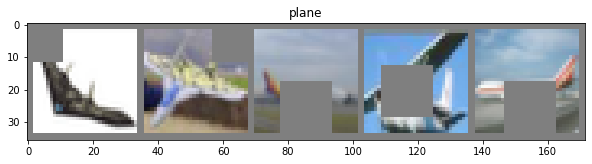

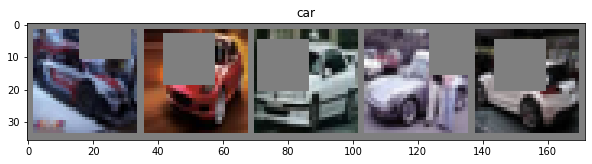

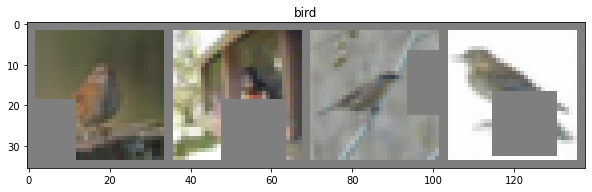

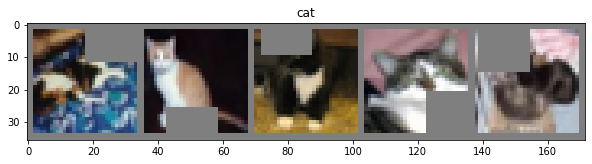

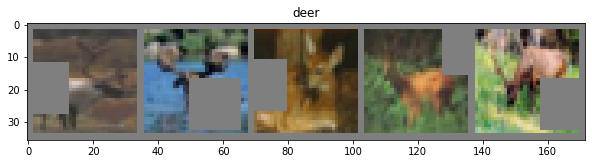

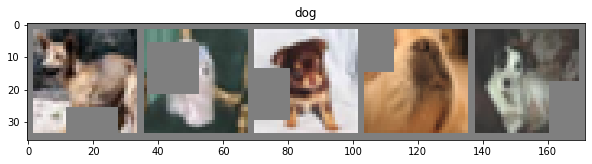

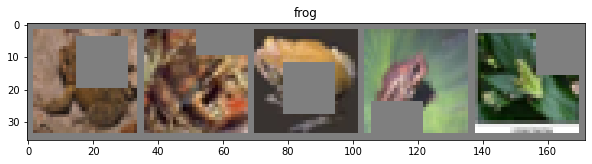

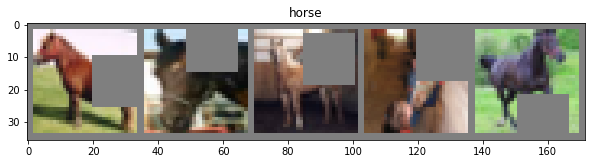

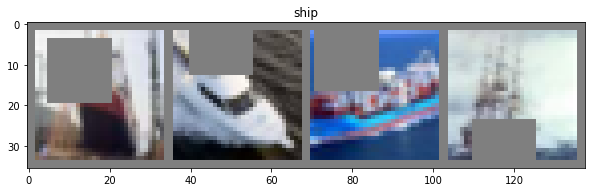

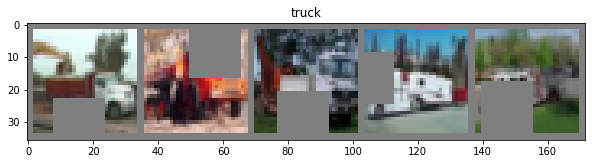

In [14]:
import torchvision
from google.colab import files
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
images, labels = iter(train_loader).next()
for i in range(len(classes)):
  index = [j for j in range(len(labels)) if labels[j] == i]
  img = torchvision.utils.make_grid(images[index[0:5]],nrow=5,padding=2,scale_each=False)
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  fig = plt.figure(figsize=(10,10))
  plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
  plt.title(classes[i])
  fig.savefig("albumentaion.png")
  files.download("albumentaion.png")




### Run the model

In [15]:
import torch.nn as nn
optimizer = helper_obj.get_l2_regularizer()
scheduler = helper_obj.get_one_cycle_lr(optimizer=optimizer, lr=0.001)
EPOCHS = 21
#l1_factor=0.0001

train_obj = Train()
test_obj = Test()
train_max_acc = []
train_min_loss = []
criterion = nn.CrossEntropyLoss()
for epoch in range(1, EPOCHS):
    print("EPOCH:", epoch)
    train_obj.train(model, device, train_loader, optimizer, criterion)
    scheduler.step()
    if epoch < EPOCHS-1:
        test_obj.test(model, device, test_loader, criterion, misclassfied_required=False, trueclassified_required=False)
    else:
        # store only last epochsreult for misclassfied and trueclassified images
        test_obj.test(model, device, test_loader, criterion, misclassfied_required=True, trueclassified_required=True)
    train_max_acc.append(train_obj.train_acc[-1])
    train_min_loss.append(train_obj.train_losses[-1])
miscassified_images = test_obj.misclassified_images
correctcassified_images = test_obj.trueclassified_images
test_losses = test_obj.test_losses
test_acc = test_obj.test_acc
print("Maximum Training Accuracy = ", max(train_max_acc))
print("Maximum Testing Accuracy = ", max(test_acc))

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


Train Set: Train Loss=1.5782785415649414 Batch_id=781 Accuracy=47.35: 100%|██████████| 782/782 [00:40<00:00, 19.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 6023/10000 (60.23%)

EPOCH: 2


Train Set: Train Loss=1.0631327629089355 Batch_id=781 Accuracy=59.21: 100%|██████████| 782/782 [00:40<00:00, 19.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0144, Accuracy: 6753/10000 (67.53%)

EPOCH: 3


Train Set: Train Loss=0.774344801902771 Batch_id=781 Accuracy=64.09: 100%|██████████| 782/782 [00:40<00:00, 19.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0138, Accuracy: 6890/10000 (68.90%)

EPOCH: 4


Train Set: Train Loss=1.6623470783233643 Batch_id=781 Accuracy=66.65: 100%|██████████| 782/782 [00:40<00:00, 19.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 6433/10000 (64.33%)

EPOCH: 5


Train Set: Train Loss=1.3670225143432617 Batch_id=781 Accuracy=68.27: 100%|██████████| 782/782 [00:40<00:00, 19.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 6339/10000 (63.39%)

EPOCH: 6


Train Set: Train Loss=1.1288976669311523 Batch_id=781 Accuracy=69.48: 100%|██████████| 782/782 [00:40<00:00, 19.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0142, Accuracy: 6834/10000 (68.34%)

EPOCH: 7


Train Set: Train Loss=1.3568518161773682 Batch_id=781 Accuracy=69.43: 100%|██████████| 782/782 [00:40<00:00, 19.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0143, Accuracy: 6956/10000 (69.56%)

EPOCH: 8


Train Set: Train Loss=0.9407563209533691 Batch_id=781 Accuracy=70.20: 100%|██████████| 782/782 [00:40<00:00, 19.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0147, Accuracy: 6871/10000 (68.71%)

EPOCH: 9


Train Set: Train Loss=0.5541990995407104 Batch_id=781 Accuracy=71.25: 100%|██████████| 782/782 [00:40<00:00, 19.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 7428/10000 (74.28%)

EPOCH: 10


Train Set: Train Loss=0.7842649221420288 Batch_id=781 Accuracy=71.52: 100%|██████████| 782/782 [00:40<00:00, 19.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 6956/10000 (69.56%)

EPOCH: 11


Train Set: Train Loss=0.7407379746437073 Batch_id=781 Accuracy=72.21: 100%|██████████| 782/782 [00:40<00:00, 19.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0121, Accuracy: 7373/10000 (73.73%)

EPOCH: 12


Train Set: Train Loss=0.39958056807518005 Batch_id=781 Accuracy=72.59: 100%|██████████| 782/782 [00:40<00:00, 19.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 7750/10000 (77.50%)

EPOCH: 13


Train Set: Train Loss=1.095768928527832 Batch_id=781 Accuracy=73.66: 100%|██████████| 782/782 [00:40<00:00, 19.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 7688/10000 (76.88%)

EPOCH: 14


Train Set: Train Loss=1.1149084568023682 Batch_id=781 Accuracy=74.46: 100%|██████████| 782/782 [00:40<00:00, 19.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 7420/10000 (74.20%)

EPOCH: 15


Train Set: Train Loss=0.7221882343292236 Batch_id=781 Accuracy=75.70: 100%|██████████| 782/782 [00:40<00:00, 19.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 7837/10000 (78.37%)

EPOCH: 16


Train Set: Train Loss=1.0633111000061035 Batch_id=781 Accuracy=77.66: 100%|██████████| 782/782 [00:41<00:00, 18.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 8142/10000 (81.42%)

EPOCH: 17


Train Set: Train Loss=0.28836166858673096 Batch_id=781 Accuracy=79.76: 100%|██████████| 782/782 [00:41<00:00, 18.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 8306/10000 (83.06%)

EPOCH: 18


Train Set: Train Loss=0.7038345336914062 Batch_id=781 Accuracy=82.11: 100%|██████████| 782/782 [00:41<00:00, 18.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 8515/10000 (85.15%)

EPOCH: 19


Train Set: Train Loss=0.3351404368877411 Batch_id=781 Accuracy=84.21: 100%|██████████| 782/782 [00:41<00:00, 18.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 8740/10000 (87.40%)

EPOCH: 20


Train Set: Train Loss=1.098529577255249 Batch_id=781 Accuracy=84.74: 100%|██████████| 782/782 [00:41<00:00, 19.04it/s]



Test set: Average loss: 0.0058, Accuracy: 8723/10000 (87.23%)

Maximum Training Accuracy =  84.74
Maximum Testing Accuracy =  87.4


### Display graphs

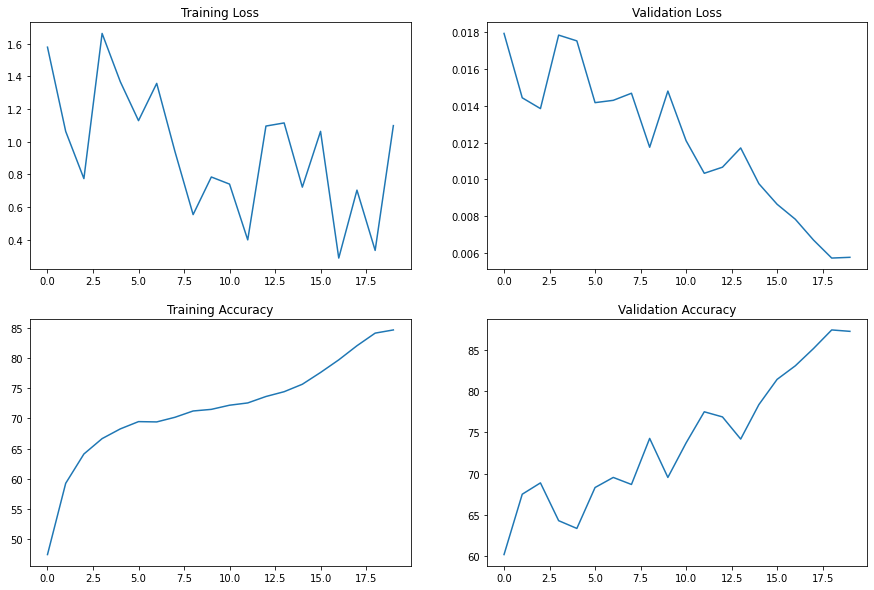

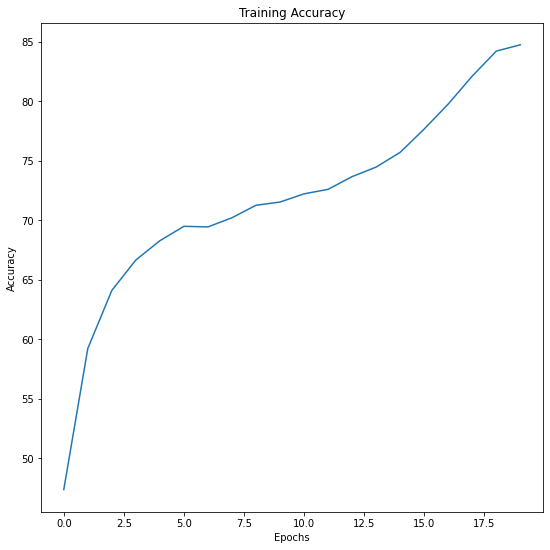

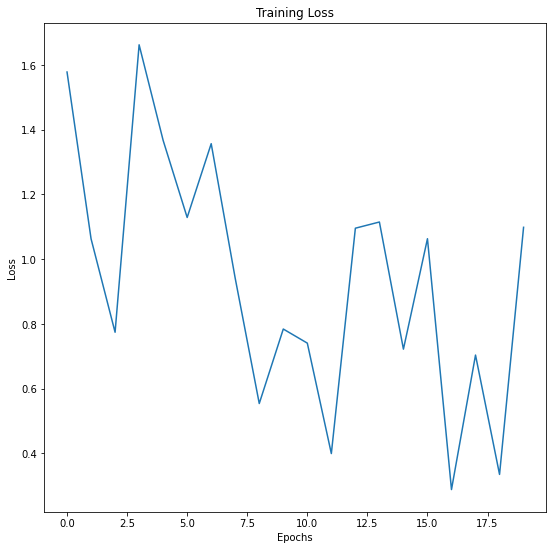

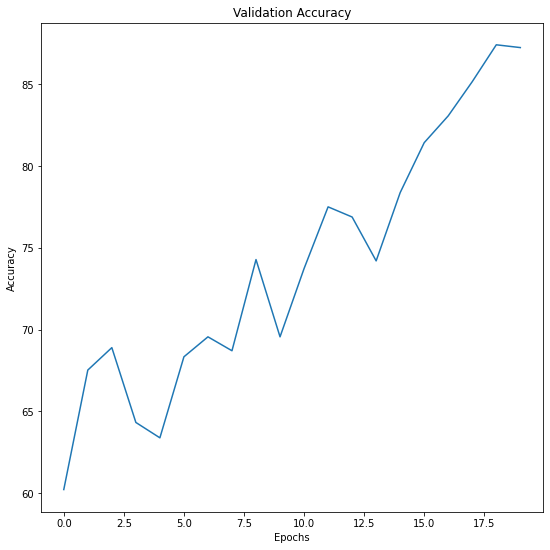

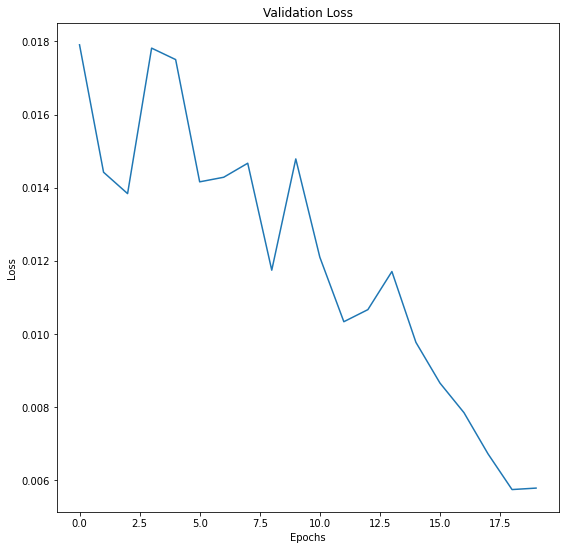

In [16]:
plt_obj = Plot(train_max_acc, train_min_loss, test_acc, test_losses)
# Plot all graph
plt_obj.display_all_plot()
#plot train accuracy graph
plt_obj.plot_train_graph()
#plot train loss graph
plt_obj.plot_train_graph(plot_case="Loss")
#plot validation accuracy graph
plt_obj.plot_validation_graph()
#plot validation loss graph
plt_obj.plot_validation_graph(plot_case="Loss")